An example of how one could compute the 5-sigma limiting depth for a position on the sky

In [1]:
import os
import sys

import astropy.units as u
import numpy as np
from astropy.time import Time

from rubin_scheduler.data import get_data_dir
from rubin_scheduler.site_models.seeing_model import SeeingModel
from rubin_scheduler.utils import m5_flat_sed, SURVEY_START_MJD
import rubin_sim.skybrightness as sb

from rubin_scheduler.site_models import (
    CloudData,
    SeeingData,
    SeeingModel,
)

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# let's find the depth of a point in the sky as a function of time
#band_name = "g"
band2indx = {"u": 0, "g": 1, "r": 2, "i": 3, "z": 4, "y": 5}
#band_indx = band2indx[band_name]

mjd0 = SURVEY_START_MJD # MJD
delta_t = 15.0 / 60.0 / 24.0  # time step, minutes to days
survey_length = 40.0  # Days
sun_limit = np.radians(-12.) # degrees to radians
nominal_expt = 30.0 # Seconds

# Set up position(s), here's my default spot in WFD
ras = np.radians([0.])
decs = np.radians([-20.])


In [3]:
seeing_model = SeeingModel()


# times we want the depths at
mjds = np.arange(mjd0, mjd0 + survey_length, delta_t)

# set 
names = ["mjd", "sun_alt", "sun_n18_rising_next"]
names.append("airmass")
for band_name in band2indx:
    names.append( "sky_%s" % band_name)
    names.append("m5_%s" % band_name)
    names.append("fwhmEff_%s" % band_name)
names.append("clouds")

types = [float] * len(names)
result = np.zeros(mjds.size, dtype=list(zip(names, types)))
result["mjd"] = mjds




In [4]:
sm = sb.SkyModel(mags=True)
mags = []
airmasses = []
sun_alts = []

maxi = mjds.size
for i, mjd in enumerate(mjds):
    try:
        sm.set_ra_dec_mjd(ras, decs, mjd, degrees=False)
    except ValueError:
        sm.sun_alt = 12.0
    if sm.sun_alt > sun_limit:
        mags.append(np.ravel(np.array(list(sm.return_mags().values())).T * 0))
        airmasses.append(sm.airmass * 0)
    else:
        mags.append(np.ravel(np.array(list(sm.return_mags().values())).T ))
        airmasses.append(sm.airmass)
    sun_alts.append(sm.sun_alt)

mags = np.array(mags)
result["airmass"] = np.ravel(airmasses)
result["sun_alt"] = sun_alts


/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness/interp_components.py:601: UserWarning: Extrapolating twilight beyond a sun altitude of -11 degrees
  warnings.warn("Extrapolating twilight beyond a sun altitude of -11 degrees")


In [6]:
# Now to look up the seeing and cloud level
mjd_time = Time(mjd0, format="mjd")
cloud_data = CloudData(mjd_time)
seeing_data = SeeingData(mjd_time)  

In [7]:
# grab the seeing and clouds, using the same values as the baseline simulation
times = Time(mjds, format="mjd")
fwhm_500 = seeing_data(times) # Seeing at zenith and 500 nm
seeing_dict = seeing_model(fwhm_500, result["airmass"]) # Convert to our airmass and filters

# using index 1 here for g. 
for band in band2indx:
    result["fwhmEff_%s" % band] = seeing_dict["fwhmEff"][band2indx[band], :]
result["clouds"] = cloud_data(times)

In [9]:
for band in band2indx:

    result["m5_%s" % band] = m5_flat_sed(band, mags[:,band2indx[band]], result["fwhmEff_%s" % band],
                                 nominal_expt, result["airmass"], nexp=1)


/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/m5_flat_sed.py:150: RuntimeWarning: divide by zero encountered in divide
  + 2.5 * np.log10(0.7 / fwhm_eff)


Text(0, 0.5, 'Cloud level ')

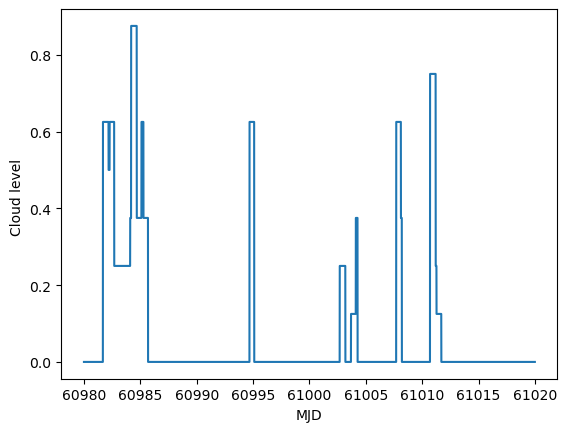

In [10]:
fig, ax = plt.subplots()

ax.plot(result["mjd"], result["clouds"])
ax.set_xlabel("MJD")
ax.set_ylabel("Cloud level ")

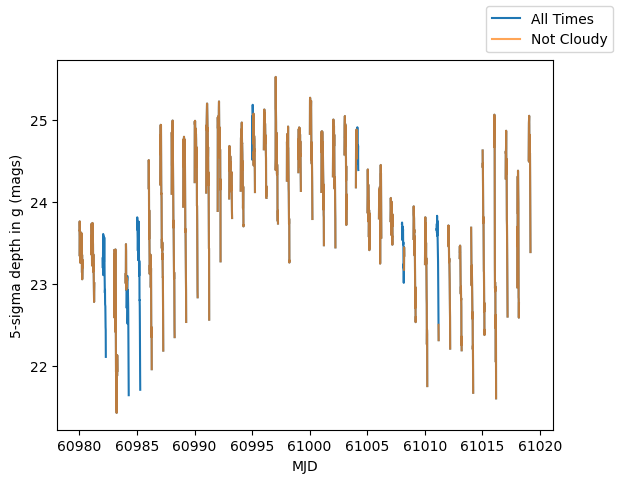

In [11]:
fig, ax = plt.subplots()

ax.plot(result["mjd"], result["m5_g"], label="All Times")

ax.set_xlabel("MJD")
ax.set_ylabel("5-sigma depth in g (mags)")
# if we remove the cloudy times
good = np.where(result["clouds"] < 0.3)[0]
ax.plot(result["mjd"][good], result["m5_g"][good], alpha=0.7, label="Not Cloudy")
leg = fig.legend()


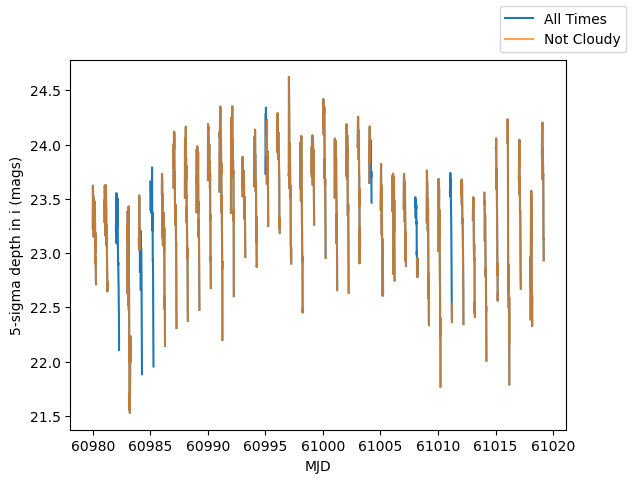

In [12]:
fig, ax = plt.subplots()

ax.plot(result["mjd"], result["m5_i"], label="All Times")

ax.set_xlabel("MJD")
ax.set_ylabel("5-sigma depth in i (mags)")
# if we remove the cloudy times
good = np.where(result["clouds"] < 0.3)[0]
ax.plot(result["mjd"][good], result["m5_i"][good], alpha=0.7, label="Not Cloudy")
leg = fig.legend()


In [13]:
# This array should have all the info needed. 
result

array([(60980.        , -0.20753044, 0., 0.        , 0.,        inf, 0.        , 0.,         inf, 0.        , 0.,         inf, 0.        , 0.,         inf, 0.        , 0.,         inf, 0.        , 0.,         inf, 0.        , 0.),
       (60980.01041667, -0.25840028, 0., 1.11226605, 0., 22.3894088, 1.18225661, 0., 23.34775056, 1.11071083, 0., 23.31514418, 1.04480336, 0., 23.22709546, 0.99901405, 0., 22.89031021, 0.96846469, 0., 22.05557005, 0.94390116, 0.),
       (60980.02083333, -0.30824924, 0., 1.08552121, 0., 22.8542559, 0.82274717, 0., 23.76003187, 0.78375245, 0., 23.70347649, 0.74834425, 0., 23.62082434, 0.7240737 , 0., 23.29351462, 0.70804726, 0., 22.48782683, 0.69526487, 0.),
       ...,
       (61019.96874999,  0.06238274, 0., 0.        , 0.,        inf, 0.        , 0.,         inf, 0.        , 0.,         inf, 0.        , 0.,         inf, 0.        , 0.,         inf, 0.        , 0.,         inf, 0.        , 0.),
       (61019.97916666,  0.01139114, 0., 0.        , 0.,        